In [1]:
#import midi2nmat as m2n
import pandas as pd
import numpy as np

In [2]:
#path="/Users/aaroncarter-enyi/Downloads/atavizm-SAR_dev/Data/a-exsultate.mid"
path="/Users/aaroncarter-enyi/Google Drive/atavizm-SAR_dev/Data/Fugue-BWV-847.mid"

In [3]:
import pandas as pd
import mido

def midi2nmat(path):
    """Returns a Note Matrix from a given MIDI files"""
    
    assert (type(path) is str), "Filepath must be a string: %r" % path
    mid = mido.MidiFile(path)
    #print("mid : ", mid.time)
    tpb = mid.ticks_per_beat

    output=pd.DataFrame(columns=["Type", "Voice", "Pitch", "Velocity", "Ticks"])

    for track in mid.tracks:
        midiframe = pd.DataFrame(columns=["Type", "Voice", "Pitch", "Velocity", "Ticks"])
        for msg in track:
            if msg.type == "note_on":
                df = pd.DataFrame({"Type":msg.type, "Voice":msg.channel, "Pitch":msg.note, "Velocity":msg.velocity, "Ticks":msg.time},\
                              index=[0])
            else:
                df = pd.DataFrame({"Type":msg.type, "Ticks":msg.time},\
                              index=[0])
            midiframe = midiframe.append(df, ignore_index=True)
        

           
            
        midiframe["Time"] = pd.Series(midiframe["Ticks"].cumsum() / tpb, index=midiframe.index)

        note_on = midiframe.loc[(midiframe["Velocity"] != 0) & (midiframe["Type"] == "note_on")]
        note_off = midiframe.loc[(midiframe["Velocity"] == 0) & (midiframe["Type"] == "note_on")]
        newdex = range(0,len(note_off))

        

        note_off = note_off.reset_index(drop=True)
        note_on = note_on.reset_index(drop=True)


        note_on["Duration"] = pd.Series(note_off["Time"] - note_on["Time"], index = note_on.index)
        print("noteon : ", note_on)
        output=output.append(note_on[["Pitch", "Time", "Velocity", "Voice", "Duration"]])
        
    
    output.reset_index(drop=True, inplace=True)
    print("output : ", output)

    return output
    

In [4]:
test = midi2nmat(path)

/Users/aaroncarter-enyi/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


noteon :      Pitch Ticks     Type Velocity Voice    Time  Duration
0      79  4080  note_on       64     0     8.5  0.235417
1      78     7  note_on       64     0    8.75  0.235417
2      79     7  note_on       64     0       9  0.472917
3      72    13  note_on       64     0     9.5  0.472917
4      75    13  note_on       64     0      10  0.472917
5      79    13  note_on       64     0    10.5  0.235417
6      78     7  note_on       64     0   10.75  0.235417
7      79     7  note_on       64     0      11  0.472917
8      81    13  note_on       64     0    11.5  0.472917
9      74    13  note_on       64     0      12  0.472917
10     79    13  note_on       64     0    12.5  0.235417
11     78     7  note_on       64     0   12.75  0.235417
12     79     7  note_on       64     0      13  0.472917
13     81    13  note_on       64     0    13.5  0.472917
14     72    13  note_on       64     0      14  0.235417
15     74     7  note_on       64     0   14.25  0.235417
16  

In [5]:
print("test : ", test)
voice=test["Voice"]
voices=voice.unique();
print("voices : ", voices)
ind=[];
for i in range(0, len(voices)):
    temp=voice[voice==i].index[0]
    ind.append(temp)
    print("voice: ", test["Time"].iloc[temp-1])
    print("voice: ", test["Time"].iloc[temp])


test :       Duration Pitch Ticks    Time Type Velocity Voice
0    0.235417    79   NaN     8.5  NaN       64     0
1    0.235417    78   NaN    8.75  NaN       64     0
2    0.472917    79   NaN       9  NaN       64     0
3    0.472917    72   NaN     9.5  NaN       64     0
4    0.472917    75   NaN      10  NaN       64     0
5    0.235417    79   NaN    10.5  NaN       64     0
6    0.235417    78   NaN   10.75  NaN       64     0
7    0.472917    79   NaN      11  NaN       64     0
8    0.472917    81   NaN    11.5  NaN       64     0
9    0.472917    74   NaN      12  NaN       64     0
10   0.235417    79   NaN    12.5  NaN       64     0
11   0.235417    78   NaN   12.75  NaN       64     0
12   0.472917    79   NaN      13  NaN       64     0
13   0.472917    81   NaN    13.5  NaN       64     0
14   0.235417    72   NaN      14  NaN       64     0
15   0.235417    74   NaN   14.25  NaN       64     0
16   0.947917    75   NaN    14.5  NaN       64     0
17   0.235417    74 

In [6]:
def _make_ContCM(arr, deg1, deg2 = None):
    """
    Creates Continous Contour Matrix for searching
    Adapted for asynchrony
    """
    
    if deg2 is None:
        deg2 = deg1
    
    degrees = deg1 + deg2
    ContCM = np.zeros((degrees,len(arr))) #creates and initializes  contour matrix w/ zeroes
    ContCM.fill(np.nan)            #fills matrix with Null values
    #print(arr)
    for n in range(0,len(arr)):    
            for i in [1,2]:
                try:
                    if arr[n] > arr[n-i] and n-i >= 0 :
                        ContCM[deg1-i, n] = 1
                    elif n-i >= 0:
                        ContCM[deg1-i, n] = 0
                except:
                    continue

            for i in [1,2]:
                try:
                    if arr[n] > arr[n+i]:
                        ContCM[deg1+i-1, n] = 1
                    else:
                        ContCM[deg1+i-1, n] = 0
                except:
                    continue
    
    return ContCM

In [7]:
def _get_segments(cmin,cmax,pitches,CL_list):    
    p = []
    for n in range(cmin,cmax): #this should be a range of cardinalities to look over
        segments = [CL_list[0][i:i+n] for i in range(0, len(pitches)-n)] #get list of all possible segments of n cardinality
        segmentu = [list(x) for x in set(tuple(x) for x in segments)] #get the unique segments from the list

        segind = [[] for i in range(0,len(segmentu))] #get the index of these occurences of these segments, this also happens to be the index of the notes they start on
        for i in range(0,len(segmentu)):
            for j in range(0,len(segments)):
                if (segments[j] == segmentu[i]).all():
                    segind[i].append(j)

        if len(segments) == len(segmentu):
            break
        
        segmentucount = np.array([len(x) for x in segind]) #get a count of all the occurences for a given segment
#         segmentpitch = [pitches[ind[i][0]-2:ind[i][0]+n-1+2] for i in range(len(ind))] #get the pitches of the original occurence

        max_ind = np.argsort(segmentucount)[::-1][:5] #the indexes of the 5 most frequent segments so that the largest is in front
        max_segmentu = np.array(segmentu)[max_ind]
        max_segmentucount = segmentucount[max_ind]
#         max_segmentpitch = np.array(segmentpitch)[max_ind]
        max_segmentucov = [i*n for i in max_segmentucount]
        max_segind = np.array(segind)[max_ind]

        p.append({"segments":segments,
                  "seg":max_segmentu,
                  "segcount":max_segmentucount,
                  "segind":max_segind,
                  "segcov":max_segmentucov}) #storing the results in a data structure for later (will have index n-1)
    return p
    

In [8]:
def SAR_Contour(nmat, s_type=3, cmin=5, cmax=10, degrees=2):
    print("nmat : ", nmat)
    pitches=list(nmat['Pitch']) #Get the list of pitches for the piece
    contcom = _make_ContCM(pitches,degrees) #convert to continuous contour matrix
    CL = np.nansum(contcom, axis=0) #get the sums of the columns of the matrix
    
    if s_type > 1:
        durs=list(nmat['Time']) #extract beat onsets as a list
        durs=[x-y for x,y in zip(durs[1:len(durs)-1],durs[0:len(durs)-2])] #convert to interonset durations by subtracting adjacent onsets
        durs.append(nmat['Duration'].iloc[-1]) #add the duration of the last note back to list
        contcom=_make_ContCM(durs,degrees) #create continuous contour matrix
        DCL = np.nansum(contcom, axis=0) #get the sums of the columns of the matrix
        
    if s_type == 1:
        CL_list = [CL, CL]
    elif s_type == 2:
        CL_list = [DCL, DCL]
    elif s_type == 3:
        CL_list = [CL,DCL]
    
    p = _get_segments(cmin,cmax,pitches,CL_list) #makes a dataframe of all the important segments needed
    
    #initialize storage variables
#     allcov = []
    r = pd.DataFrame(columns=['card','seg','segcount','segind','cov','invind'])
    
    for i in range(0,len(p)):
        for j in range(0,len(p[i]["seg"])):
            r = r.append({"card":len(p[i]["seg"][j]),
                  "seg":p[i]["seg"][j],
                  "segcount":p[i]["segcount"][j],
                  "segind":p[i]["segind"][j],
                  "cov":p[i]["segcov"][j],
                  "invind":[]}, ignore_index=True)
#             allcov.append(p[i]["segcov"][j])

    r = r.sort_values(by=["cov"], ascending=False).reset_index(drop=True)

    s = []

    for i in range(0,len(r)):
        inds=[];
        for j in range(0,len(r["segind"].iloc[i])):
            a=r["segind"].iloc[i][j]
            b=r["segind"].iloc[i][j]+r["card"].iloc[i]-1
            temp=list(range(a,b))
            inds=inds+temp
        #print("inds : ", inds)
        s.append(inds)
        
    r["inds"] = pd.Series(s, index=r.index) 
    
    for i in range(len(r)-1,1,-1):
        print("lenr : ", len(r))
        print("i : ", i)
        b=r["inds"].iloc[i]
        print("b : ", b)
        for j in range(0,i-1):
            a=r["inds"].iloc[j]
            print("a : ", a)
            if set(b).issubset(set(a)):
                print("yes")
                print("rtest : ", r["inds"].iloc[i])
                r.drop(r.index[i], inplace=True)
                break
                
    r = r.sort_values(by=["cov"], ascending=False).reset_index(drop=True)
    
    return {"r":r, "p":p, "CL":CL_list, "nmat":nmat}

In [9]:
tuh = SAR_Contour(test)

nmat :       Duration Pitch Ticks    Time Type Velocity Voice
0    0.235417    79   NaN     8.5  NaN       64     0
1    0.235417    78   NaN    8.75  NaN       64     0
2    0.472917    79   NaN       9  NaN       64     0
3    0.472917    72   NaN     9.5  NaN       64     0
4    0.472917    75   NaN      10  NaN       64     0
5    0.235417    79   NaN    10.5  NaN       64     0
6    0.235417    78   NaN   10.75  NaN       64     0
7    0.472917    79   NaN      11  NaN       64     0
8    0.472917    81   NaN    11.5  NaN       64     0
9    0.472917    74   NaN      12  NaN       64     0
10   0.235417    79   NaN    12.5  NaN       64     0
11   0.235417    78   NaN   12.75  NaN       64     0
12   0.472917    79   NaN      13  NaN       64     0
13   0.472917    81   NaN    13.5  NaN       64     0
14   0.235417    72   NaN      14  NaN       64     0
15   0.235417    74   NaN   14.25  NaN       64     0
16   0.947917    75   NaN    14.5  NaN       64     0
17   0.235417    74 

In [10]:
tuh["r"]

,card,seg,segcount,segind,cov,invind,inds
0,6,"[2.0, 2.0, 2.0, 2.0, 1.0, 0.0]",15,"[39, 124, 285, 434, 501, 538, 546, 554, 562, 5...",90,[],"[39, 40, 41, 42, 43, 124, 125, 126, 127, 128, ..."
1,9,"[2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 4.0, 3.0, 2.0]",10,"[39, 124, 285, 434, 546, 562, 570, 663, 679, 695]",90,[],"[39, 40, 41, 42, 43, 44, 45, 46, 124, 125, 126..."
2,5,"[2.0, 2.0, 2.0, 1.0, 0.0]",17,"[40, 125, 216, 286, 435, 502, 539, 547, 555, 5...",85,[],"[40, 41, 42, 43, 125, 126, 127, 128, 216, 217,..."
3,6,"[2.0, 1.0, 0.0, 4.0, 3.0, 2.0]",13,"[42, 127, 280, 288, 437, 478, 533, 549, 565, 5...",78,[],"[42, 43, 44, 45, 46, 127, 128, 129, 130, 131, ..."
4,7,"[2.0, 2.0, 1.0, 0.0, 4.0, 3.0, 2.0]",11,"[41, 126, 287, 436, 477, 548, 564, 572, 665, 6...",77,[],"[41, 42, 43, 44, 45, 46, 126, 127, 128, 129, 1..."
5,9,"[1.0, 3.0, 1.0, 2.0, 4.0, 0.0, 2.0, 1.0, 2.0]",8,"[4, 75, 164, 247, 267, 385, 520, 729]",72,[],"[4, 5, 6, 7, 8, 9, 10, 11, 75, 76, 77, 78, 79,..."
6,9,"[0.0, 1.0, 3.0, 1.0, 2.0, 4.0, 0.0, 2.0, 1.0]",8,"[3, 74, 163, 246, 266, 384, 519, 728]",72,[],"[3, 4, 5, 6, 7, 8, 9, 10, 74, 75, 76, 77, 78, ..."
7,9,"[1.0, 2.0, 4.0, 0.0, 2.0, 1.0, 2.0, 4.0, 0.0]",8,"[6, 77, 166, 249, 269, 387, 522, 731]",72,[],"[6, 7, 8, 9, 10, 11, 12, 13, 77, 78, 79, 80, 8..."
8,9,"[3.0, 0.0, 1.0, 3.0, 1.0, 2.0, 4.0, 0.0, 2.0]",8,"[2, 73, 162, 245, 265, 383, 518, 727]",72,[],"[2, 3, 4, 5, 6, 7, 8, 9, 73, 74, 75, 76, 77, 7..."
9,5,"[1.0, 0.0, 4.0, 3.0, 2.0]",14,"[43, 128, 212, 281, 289, 438, 479, 534, 550, 5...",70,[],"[43, 44, 45, 46, 128, 129, 130, 131, 212, 213,..."


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

def plot(nmat,segind,segcard):
    """
    plot(nmat,segind,segcard)
    ######################################################
    
    Displays Arc Plot Diagram. This consists of a series of arcs overlayed on MIDI data presented horizontally.
    
    Parameters:
        nmat (pandas.df): A Note Matrix that contains pitch, timing, and velocity information for a series of notes.
        nmatRCE (pandas.df): A version of the Note Matrix which has each element reduced to a binary value.
        onsets (list): A list of values that describes when each note would begin in the piece.
        offsets (list): A list of values that describes when each note would end in the piece.
        segind (list): A list of lists of values that describe the occurences of each pattern found in the piece.
        segcard (list): A list that describes how many notes should be in each pattern.
    """
    
    onsets = nmat['Time']
    offsets = onsets + nmat['Duration']
    pitch = nmat['Pitch']
    
    _midiplot(onsets,offsets,pitch)

    colornum=1
    #cmap1=jet(len(segcard))
    #cmap1 = plt.cm.get_cmap('jet')
    pitchmax=nmat['Pitch'].max()
    pitchmean=nmat['Pitch'].mean()
    pitchmean=(pitchmax+pitchmean)/2

    #segind=[1,72,161,244,264,382,517,726]
    framelabels = ["Onset in Beats", "Durations in Beats", "Pitch (C4=60)"]
    #segcard=20
    rads = [1]
    # for i in range(0,len(segind)-1):
    #try:
    temp=onsets[segind]
    temp=temp.sort_values()
    #SortInd = temp.head() 
    SortInd=list(temp.index.values) 
    #r = r.sort_values(by=["cov"], ascending=False).reset_index(drop=True)
    #print("onsets : ", temp)
    #print("onsets : ", SortInd)
    ind=SortInd
    segind=ind
    #print("onsets : ", ind)
    #print("segind : ", segind)
    #finally:
    #    pass
    #     try
    #         try
    #             simind=r(i).simind;
    #         catch
    #             simind=r(i).invind;
    #         end
    #     catch
    #         simind=[];
    #     end
    #       ind
    origxstart = onsets[segind[0]]
    #print("origxstart: ", origxstart)
    card=segcard
    #print("card : ", card)
    origxend=offsets[segind[0]+card-1]
    origwidth=origxend - origxstart
    origx=(origwidth) / 2 + origxstart
    linewidthstart= origwidth #need to normalize to pixel length
    print("linewidthstart : ", linewidthstart)
    origpitchmin=min(pitch[segind[0]:(segind[0] + card - 1)]) - 2
    colornoalpha=[colornum]
    colornum=colornum + 1
    
    for j in range(1,len(ind)):
        #noteInd = ind[j]
        #compxstart=nmat.iloc[noteInd,0]
        compxstart = onsets[ind[j]]
        print("start : ", compxstart)
        #compxend=nmat.iloc[noteInd + (card - 1),0] + nmat.iloc[noteInd + (card - 1),1]
        compxend = offsets[ind[j]+card-1]
        print("end : ", compxend)
        compwidth=compxend - compxstart
        compx=(compwidth) / 2 + compxstart
        linewidthend= compwidth #need to normalize to pixel length
        print("linewidthend : ", linewidthend)
        comppitchmin=min(pitch[ind[j]:ind[j] + (card - 1)]) - 2
        rad=(compx - origx) / 2
        rads.append(rad)
        x=rad + origx
        nsegments=100
        linewidth=np.dot(card,3)
        
        if segcard:
            colornoalpha=[0,0,1]
            
        coloralpha=colornoalpha.append(0.5)
        _arc(x=x,y=pitchmean,r=rad,linewidthstart=linewidthstart,linewidthend=linewidthend)

def _arc(x,y,r,nsegments=100,coloralpha='r',linewidthstart=5,linewidthend=10):
    """
    _arc(x,y,r,nsegments=100,coloralpha='r',linewidthstart=5,linewidthend=10)
    #########################################################################
    
    Draws an arc from one point to another.
    
    Parameters:
        x (float): The time value the arc will start at.
        y (float): The pitch value the arc will start at.
        r (float): The radius of the arc.
        nsegments (int): The number of line segments that make up the arc.
        coloralpha (str): The color of the line segments.
        linewidthstart (int): the width of each line segment at the beginning.
        linewidthend (int): the width of each line segment at the end.
    """
    th=np.arange(0,np.pi,np.pi/200)
    xunit=r * np.cos(th) + x;
    yunit=r * np.sin(th) + y;
    linewidthincrement=(linewidthstart-linewidthend)/len(xunit);

    plt.figure(1)
    for i in range(2,len(th)):
        plt.plot([xunit[i-1],xunit[i]], [yunit[i-1],yunit[i]],'b',linewidth = 10*(linewidthend+i*linewidthincrement), zorder=0, alpha=0.05)
        
def _midiplot(onsets,offsets,pitch):
    plt.figure(figsize=(20,10))
    
    for i in range(0,len(onsets)):
        #try:
            #print("onsets : ", i)
        plt.plot([onsets[i],offsets[i]], [pitch[i],pitch[i]], 'k', lw=2, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()], zorder=5)
        #except:
          #  print("An exception occurred")
    plt.xlabel("Beats")
    plt.ylabel("Pitch (C4=60)")

linewidthstart :  3.7354166666666666
start :  9.0
end :  12.735416666666667
linewidthend :  3.7354166666666675
start :  25.0
end :  28.735416666666666
linewidthend :  3.7354166666666657
start :  41.0
end :  44.735416666666666
linewidthend :  3.7354166666666657
start :  57.0
end :  60.735416666666666
linewidthend :  3.7354166666666657
start :  77.0
end :  80.73541666666667
linewidthend :  3.7354166666666657
start :  103.0
end :  106.73541666666667
linewidthend :  3.7354166666666657
start :  115.0
end :  118.73541666666667
linewidthend :  3.7354166666666657


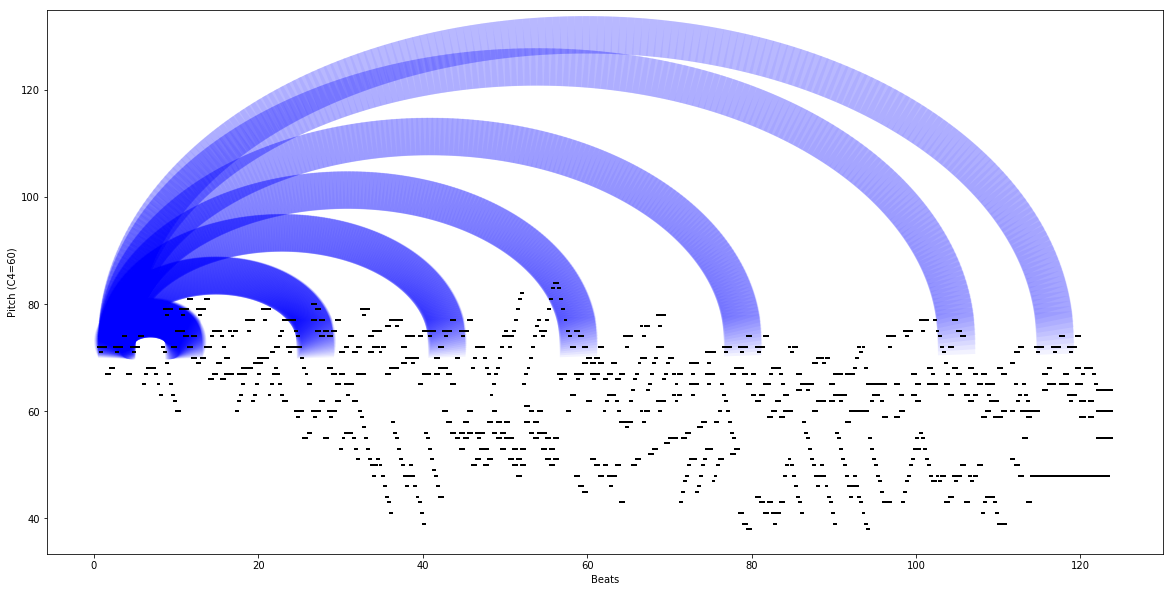

In [16]:
i=8
plot(test,tuh["r"]['segind'].iloc[i],tuh["r"]['card'].iloc[i])

In [17]:
from tkinter import *

class Window(Frame):

    def __init__(self, master=None):
        # parameters that you want to send through the Frame class. 
        Frame.__init__(self, master)   

        #reference to the master widget, which is the tk window                 
        self.master = master

        #with that, we want to then run init_window, which doesn't yet exist
        self.init_window()

        
            #Creation of init_window
    def init_window(self):

        # changing the title of our master widget      
        self.master.title("GUI")

        # allowing the widget to take the full space of the root window
        self.pack(fill=BOTH, expand=1)

        # creating a button instance
        quitButton = Button(self, text="Quit", command=self.client_exit)

        # placing the button on my window
        quitButton.place(x=0, y=0)

 
    def client_exit(self):
        print("hello")
        self.destroy()

# root window created. Here, that would be the only window, but
# you can later have windows within windows.

root = Tk()

#size of the window
root.geometry("400x300")

#creation of an instance
app = Window(root)

#mainloop 
root.mainloop()  

hello
